In [18]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
!nvidia-smi

Tue Nov 17 19:52:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    33W /  70W |   2271MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import math
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     
print(device)

cuda


# [b] Identfying global minimum for LR

In [9]:
# Reading in the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            #nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

In [14]:
# Get $\eta_{max}$
lr_val, lossval = [], []
model = allcnn_t().to(device)
epochs = 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9, weight_decay=0.001, nesterov=True)


total_step = len(train_loader)
overall_step = 0
for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to configured device
        images = images.to(device)
        labels = labels.to(device)
        #Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
        lossval.append(loss.item())
        lr_val.append(optimizer.param_groups[0]['lr'])
        for g in optimizer.param_groups:
            g['lr'] = g['lr'] * 1.1
        
        if i >= 180:
            break

Num parameters:  1667166
Epoch [1/1], Step [1/391], Loss: 2.3118
Epoch [1/1], Step [11/391], Loss: 2.2951
Epoch [1/1], Step [21/391], Loss: 2.3052
Epoch [1/1], Step [31/391], Loss: 2.2508
Epoch [1/1], Step [41/391], Loss: 2.1876
Epoch [1/1], Step [51/391], Loss: 2.1633
Epoch [1/1], Step [61/391], Loss: 2.0782
Epoch [1/1], Step [71/391], Loss: 1.8801
Epoch [1/1], Step [81/391], Loss: 1.8016
Epoch [1/1], Step [91/391], Loss: 1.8086
Epoch [1/1], Step [101/391], Loss: 1.7695
Epoch [1/1], Step [111/391], Loss: 1.8023
Epoch [1/1], Step [121/391], Loss: 1.9793
Epoch [1/1], Step [131/391], Loss: 1.6773
Epoch [1/1], Step [141/391], Loss: 1.9715
Epoch [1/1], Step [151/391], Loss: 4.8861
Epoch [1/1], Step [161/391], Loss: 35.9736
Epoch [1/1], Step [171/391], Loss: 101.8028
Epoch [1/1], Step [181/391], Loss: 165.7047


Value of n_max =2.4046344822914127


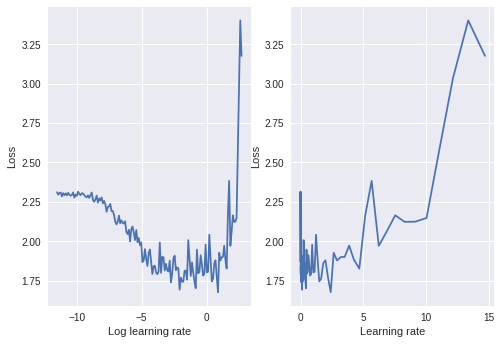

In [15]:
import matplotlib.pyplot as plt
print("Value of n_max =" + str(lr_val[np.argmin(lossval[:180])]))
nstar = lr_val[np.argmin(lossval[:180])] / 10

plt.style.use("seaborn")
plt.subplot(1,2, 1)
plt.xlabel("Log learning rate")
plt.ylabel("Loss")
plt.plot(np.log(lr_val[:150]), lossval[:150])

plt.subplot(1,2, 2)
plt.ylabel("Loss")
plt.xlabel("Learning rate")

plt.plot(lr_val[:150], lossval[:150])

# [C] Training with Cosine learning schedule with Warmup

In [16]:
def train(net, optimizer, criterion, train_loader, test_loader, epochs, eta_star):
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []
    lrvalues = []
    alltrain_acc = []
    alltrain_loss = []

    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    Tmax = 19550
    T0 = Tmax // 5
   
    
    for epoch in range(epochs):
        
        model.train()
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(train_loader):
            overall_step += 1
            if overall_step <= T0:
                for g in optimizer.param_groups:
                    g['lr'] = 0.0001 + (eta_star * overall_step)/float(T0)
            else:
                for g in optimizer.param_groups:
                    g['lr'] = 0.000001 + eta_star * np.cos((math.pi * (overall_step - T0))/(2* (Tmax - T0)))
            lrvalues.append(optimizer.param_groups[0]['lr'])        
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            alltrain_loss.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            alltrain_acc.append(float(correct)/total)
            
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            tot_loss = 0.0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels).item()
                tot_loss = tot_loss + loss * labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            if epoch % 10 == 0:
                print('Test accuracy at Epoch %d: %0.2f' % (epoch+1, (100 * correct / total)))
                print('Test loss at Epoch %d: %0.2f' % (epoch+1, (float(tot_loss) / total)))

            val_loss.append(float(tot_loss)/total)
            val_acc.append(100 * correct/float(total)) 
            
            correct = 0
            total = 0
            tot_loss = 0.0
            for i, (images, labels) in enumerate(train_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels).item()
                tot_loss = tot_loss + loss * labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            if epoch % 10 == 0:
                print('Train accuracy at Epoch %d: %0.2f' % (epoch+1, (100 * correct / total)))
                print('Train loss at Epoch %d: %0.2f' % (epoch+1, (float(tot_loss) / total)))

            train_acc.append(100 * correct/ float(total))
            train_loss.append(float(tot_loss)/total)
    return train_acc, train_loss, val_acc, val_loss, alltrain_acc, alltrain_loss, lrvalues

In [25]:
# The training loop
model = allcnn_t().to(device)
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9,
                      weight_decay=0.0001, nesterov=True)

# Training loop called here
met = train(model, optimizer, criterion, trainloader,
            testloader, epochs, eta_star=nstar)
train_acc, train_loss, val_acc, val_loss, alltrain_acc, alltrain_loss, lrvalues = met

Num parameters:  1667166
Test accuracy at Epoch 1: 37.35
Test loss at Epoch 1: 1.72
Train accuracy at Epoch 1: 38.13
Train loss at Epoch 1: 1.72
Test accuracy at Epoch 11: 83.42
Test loss at Epoch 11: 0.50
Train accuracy at Epoch 11: 88.13
Train loss at Epoch 11: 0.35
Test accuracy at Epoch 21: 87.78
Test loss at Epoch 21: 0.39
Train accuracy at Epoch 21: 97.25
Train loss at Epoch 21: 0.09
Test accuracy at Epoch 31: 89.29
Test loss at Epoch 31: 0.36
Train accuracy at Epoch 31: 99.75
Train loss at Epoch 31: 0.02
Test accuracy at Epoch 41: 90.31
Test loss at Epoch 41: 0.36
Train accuracy at Epoch 41: 99.99
Train loss at Epoch 41: 0.00


Text(0, 0.5, 'Learning rate')

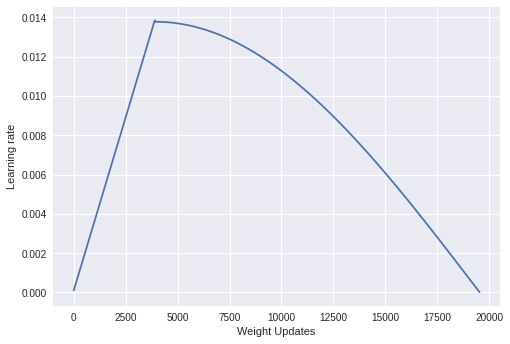

In [26]:
import matplotlib.pyplot as plt
lrvalues2 = np.array(lrvalues)
lrvalues2 = lrvalues2[ range(0, len(lrvalues), 20)]
plt.plot(np.array(range(len(lrvalues2))) * 20, lrvalues2)
plt.xlabel("Weight Updates")
plt.ylabel("Learning rate")

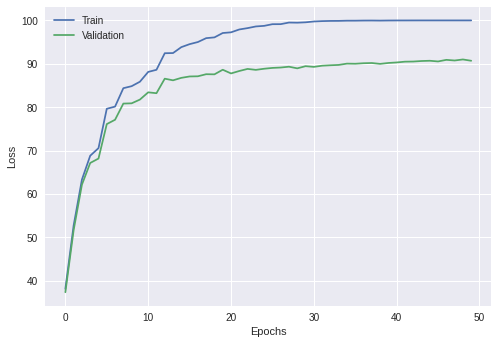

In [27]:
plt.style.use('seaborn')
steps = range(len(train_acc))
plt.plot(steps, train_acc)
plt.plot(steps, val_acc)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

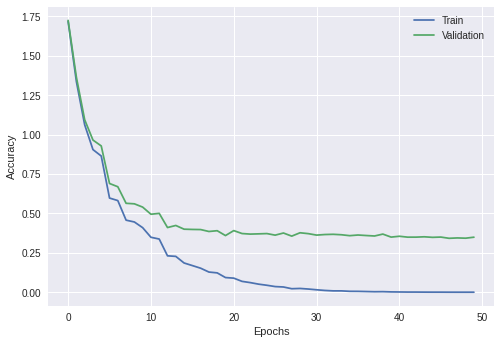

In [28]:
plt.style.use('seaborn')
steps = range(len(train_acc))
plt.plot(steps, train_loss)
plt.plot(steps, val_loss)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])

Text(0, 0.5, 'Batch Accuracy')

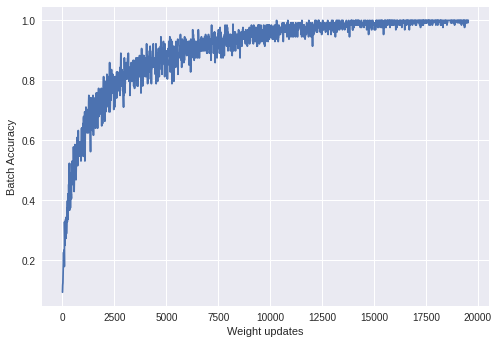

In [29]:
plt.style.use('seaborn')
alltrain_acc2 = np.array(alltrain_acc)
alltrain_acc2 = alltrain_acc2[ range(0, len(alltrain_acc), 10)] 
steps = np.array(range(len(alltrain_acc2))) * 10
plt.plot(steps, alltrain_acc2)
plt.xlabel("Weight updates")
plt.ylabel("Batch Accuracy")

Text(0, 0.5, 'Batch Loss')

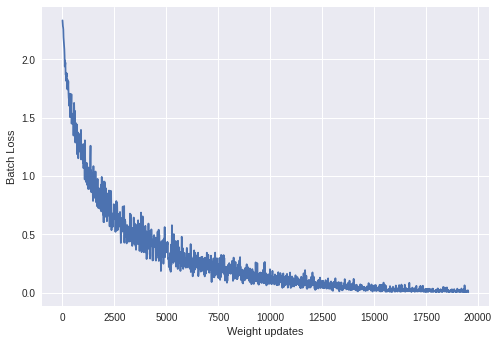

In [30]:
plt.style.use('seaborn')
alltrain_loss2 = np.array(alltrain_loss)
alltrain_loss2 = alltrain_loss2[ range(0, len(alltrain_loss), 10)]
steps = np.array(range(len(alltrain_loss2))) * 10
plt.plot(steps, alltrain_loss2)
plt.xlabel("Weight updates")
plt.ylabel("Batch Loss")

# [d] Relationship between Hyper-parameters

In [18]:
from copy import deepcopy

model = allcnn_t().to(device)
epochs = 50
criterion = nn.CrossEntropyLoss()
training_ac = []
training_l = []
validate_ac = []
validate_l = []

params = [(nstar, 0.9), (5 * nstar, 0.5), (nstar, 0.5)]

for lr, mom in params:
    model = allcnn_t().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=mom,
                          weight_decay=0.0001, nesterov=True)
    # Training loop called here
    ans = train(model, optimizer, criterion, train_loader,
                test_loader, epochs, eta_star=lr)
    training_ac.append(deepcopy(ans[0]))
    training_l.append(deepcopy(ans[1]))
    validate_ac.append(deepcopy(ans[2]))
    validate_l.append(deepcopy(ans[3]))


Num parameters:  1667166
Num parameters:  1667166
Test accuracy at Epoch 1: 58.86
Test loss at Epoch 1: 1.15
Train accuracy at Epoch 1: 60.42
Train loss at Epoch 1: 1.11
Test accuracy at Epoch 11: 85.19
Test loss at Epoch 11: 0.44
Train accuracy at Epoch 11: 91.07
Train loss at Epoch 11: 0.26
Test accuracy at Epoch 21: 85.64
Test loss at Epoch 21: 0.45
Train accuracy at Epoch 21: 93.56
Train loss at Epoch 21: 0.19
Test accuracy at Epoch 31: 88.02
Test loss at Epoch 31: 0.39
Train accuracy at Epoch 31: 97.77
Train loss at Epoch 31: 0.07
Test accuracy at Epoch 41: 89.87
Test loss at Epoch 41: 0.35
Train accuracy at Epoch 41: 99.83
Train loss at Epoch 41: 0.01
Num parameters:  1667166
Test accuracy at Epoch 1: 50.45
Test loss at Epoch 1: 1.41
Train accuracy at Epoch 1: 51.77
Train loss at Epoch 1: 1.39
Test accuracy at Epoch 11: 78.18
Test loss at Epoch 11: 0.68
Train accuracy at Epoch 11: 83.28
Train loss at Epoch 11: 0.48
Test accuracy at Epoch 21: 85.21
Test loss at Epoch 21: 0.48
Trai

[1.111709586906433, 0.8802690243530273, 0.6277376639747619, 0.5573738640022278, 0.45889115792274476, 0.5184379937171936, 0.3697262488555908, 0.3607550284099579, 0.3310598646640778, 0.36760471457481386, 0.26350364107131957, 0.2338651046514511, 0.25739249853134155, 0.2349444051361084, 0.22924645308494568, 0.24308502474308014, 0.20794521998405457, 0.21757207097053527, 0.17737396107673645, 0.19126648036003113, 0.1890055871295929, 0.14848866726875304, 0.19353419521331788, 0.1272729857349396, 0.13426379429340363, 0.11462240771770477, 0.10882126868009567, 0.1175039064693451, 0.09251663056373596, 0.08655799436330795, 0.07054381330847741, 0.10360128799438477, 0.07982888526916504, 0.0523536290371418, 0.04338601287126541, 0.03623995984911919, 0.05044332490503788, 0.01664733010649681, 0.01873176930785179, 0.018898689488470555, 0.010129375024735928, 0.007941109091490508, 0.006462623115628958, 0.003952574240118265, 0.00224228480309248, 0.0016727547689527273, 0.0011997033572755753, 0.0007143376967869

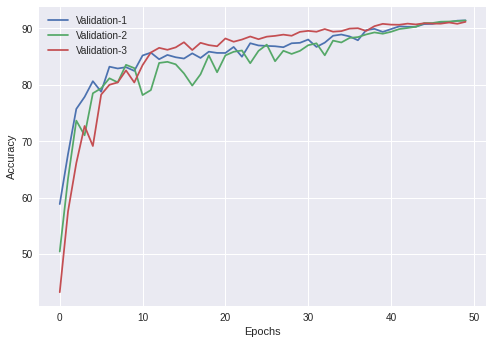

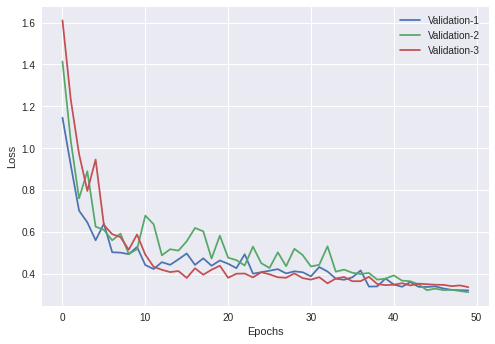

In [20]:
print(training_l[0])
steps = range(len(training_ac[0]))
plt.plot(steps, validate_ac[0])
plt.plot(steps, validate_ac[1])
plt.plot(steps, validate_ac[2])

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Validation-1", "Validation-2","Validation-3"])
plt.show()

steps = range(len(training_ac[0]))

plt.plot(steps, validate_l[0])
plt.plot(steps, validate_l[1])
plt.plot(steps, validate_l[2])
plt.legend(["Validation-1", "Validation-2","Validation-3"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

[1.111709586906433, 0.8802690243530273, 0.6277376639747619, 0.5573738640022278, 0.45889115792274476, 0.5184379937171936, 0.3697262488555908, 0.3607550284099579, 0.3310598646640778, 0.36760471457481386, 0.26350364107131957, 0.2338651046514511, 0.25739249853134155, 0.2349444051361084, 0.22924645308494568, 0.24308502474308014, 0.20794521998405457, 0.21757207097053527, 0.17737396107673645, 0.19126648036003113, 0.1890055871295929, 0.14848866726875304, 0.19353419521331788, 0.1272729857349396, 0.13426379429340363, 0.11462240771770477, 0.10882126868009567, 0.1175039064693451, 0.09251663056373596, 0.08655799436330795, 0.07054381330847741, 0.10360128799438477, 0.07982888526916504, 0.0523536290371418, 0.04338601287126541, 0.03623995984911919, 0.05044332490503788, 0.01664733010649681, 0.01873176930785179, 0.018898689488470555, 0.010129375024735928, 0.007941109091490508, 0.006462623115628958, 0.003952574240118265, 0.00224228480309248, 0.0016727547689527273, 0.0011997033572755753, 0.0007143376967869

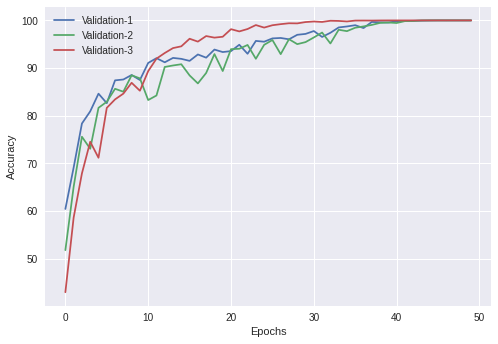

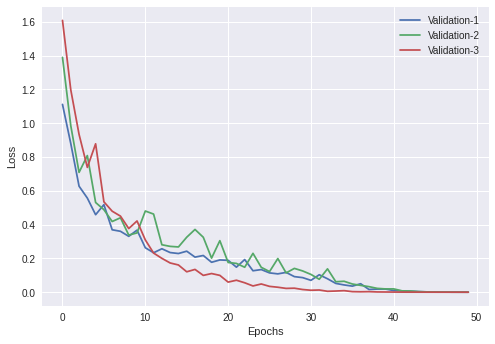

In [21]:
print(training_l[0])
steps = range(len(training_ac[0]))
plt.plot(steps, training_ac[0])
plt.plot(steps, training_ac[1])
plt.plot(steps, training_ac[2])

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Validation-1", "Validation-2","Validation-3"])
plt.show()

steps = range(len(training_ac[0]))

plt.plot(steps, training_l[0])
plt.plot(steps, training_l[1])
plt.plot(steps, training_l[2])
plt.legend(["Validation-1", "Validation-2","Validation-3"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()